In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt

import os
from PIL import Image
from pathlib import Path
import csv

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import tensorflow as tf
import librosa.display



In [2]:
songname = f'../input/gtzan-genre-collection/genres/blues/blues.00000.au'
y, sr = librosa.load(songname, mono=True, duration=2, offset=0)
ps = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=256, n_fft=512, n_mels=128)
ps = librosa.power_to_db(ps**2)
ps.shape

dataset = []
genres = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 
          'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}

for genre, genre_number in genres.items():
    for filename in os.listdir(f'../input/gtzan-genre-collection/genres/{genre}'):
        songname = f'../input/gtzan-genre-collection/genres/{genre}/{filename}'
        for index in range(14):
            y, sr = librosa.load(songname, mono=True, duration=2, offset=index*2)
            ps = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=256, n_fft=512, n_mels=64)
            ps = librosa.power_to_db(ps**2)
            dataset.append((ps, genre_number))

print(len(dataset))
import random



14000


In [3]:
random.shuffle(dataset)

train = dataset[:10000]
valid = dataset[10000:12000]
test = dataset[12000:]

X_train, Y_train = zip(*train)
X_valid, Y_valid = zip(*valid)
X_test, Y_test = zip(*test)

# Reshape for CNN input
X_train = np.array([x.reshape((64, 173, 1)) for x in X_train])
X_valid = np.array([x.reshape((64, 173, 1)) for x in X_valid])
X_test = np.array([x.reshape((64, 173, 1)) for x in X_test])

# One-Hot encoding for classes
Y_train = np.array(tf.keras.utils.to_categorical(Y_train, 10))
Y_valid = np.array(tf.keras.utils.to_categorical(Y_valid, 10))
Y_test = np.array(tf.keras.utils.to_categorical(Y_test, 10))



In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, BatchNormalization

lstm_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.3),

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.3),

    Conv1D(filters=256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.3),

    Bidirectional(LSTM(128, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),

    Bidirectional(LSTM(64, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(32),
    BatchNormalization(),
    Dropout(0.3),

    Dense(10, activation='softmax')
])

In [5]:
# Updated GRU Model with Batch Normalization, Dropout, L2 Regularization, and Learning Rate Schedule
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.GRU(64, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.GRU(32, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.GRU(16),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation='softmax')
])



In [6]:
# Updated CNN Model with Batch Normalization, Dropout, L2 Regularization, and Learning Rate Schedule
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 173, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation='softmax')
])




In [7]:
# Compile models
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss="categorical_crossentropy", metrics=['accuracy'])
gru_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss="categorical_crossentropy", metrics=['accuracy'])
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss="categorical_crossentropy", metrics=['accuracy'])



In [8]:
# Training models
lstm_history = lstm_model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_data=(X_valid, Y_valid))


Epoch 1/100
157/157 [==============================] - 31s 108ms/step - loss: 2.1431 - accuracy: 0.2808 - val_loss: 2.2204 - val_accuracy: 0.1950
Epoch 2/100
157/157 [==============================] - 14s 87ms/step - loss: 1.8129 - accuracy: 0.3574 - val_loss: 1.7857 - val_accuracy: 0.3480
Epoch 3/100
157/157 [==============================] - 14s 90ms/step - loss: 1.7000 - accuracy: 0.3909 - val_loss: 1.6730 - val_accuracy: 0.3915
Epoch 4/100
157/157 [==============================] - 14s 87ms/step - loss: 1.6268 - accuracy: 0.4206 - val_loss: 1.6624 - val_accuracy: 0.4245
Epoch 5/100
157/157 [==============================] - 15s 93ms/step - loss: 1.5933 - accuracy: 0.4334 - val_loss: 2.0313 - val_accuracy: 0.3180
Epoch 6/100
157/157 [==============================] - 14s 87ms/step - loss: 1.5358 - accuracy: 0.4594 - val_loss: 2.2419 - val_accuracy: 0.2500
Epoch 7/100
157/157 [==============================] - 14s 89ms/step - loss: 1.5080 - accuracy: 0.4673 - val_loss: 1.5261 - val_a

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



157/157 [==============================] - 14s 89ms/step - loss: 0.5194 - accuracy: 0.8322 - val_loss: 1.4955 - val_accuracy: 0.5980
Epoch 85/100
157/157 [==============================] - 14s 86ms/step - loss: 0.5142 - accuracy: 0.8316 - val_loss: 0.9779 - val_accuracy: 0.7165
Epoch 86/100
157/157 [==============================] - 14s 88ms/step - loss: 0.5151 - accuracy: 0.8319 - val_loss: 0.9772 - val_accuracy: 0.7200
Epoch 87/100
157/157 [==============================] - 14s 86ms/step - loss: 0.4974 - accuracy: 0.8372 - val_loss: 1.2383 - val_accuracy: 0.6400
Epoch 88/100
157/157 [==============================] - 14s 87ms/step - loss: 0.5082 - accuracy: 0.8330 - val_loss: 0.9926 - val_accuracy: 0.7175
Epoch 89/100
157/157 [==============================] - 14s 88ms/step - loss: 0.4799 - accuracy: 0.8430 - val_loss: 0.9188 - val_accuracy: 0.7240
Epoch 90/100
157/157 [==============================] - 14s 87ms/step - loss: 0.5056 - accuracy: 0.8318 - val_loss: 1.2411 - val_accuracy

In [9]:
gru_history = gru_model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_data=(X_valid, Y_valid))


Epoch 1/100
157/157 [==============================] - 50s 246ms/step - loss: 2.7176 - accuracy: 0.1535 - val_loss: 2.4177 - val_accuracy: 0.1725
Epoch 2/100
157/157 [==============================] - 39s 245ms/step - loss: 2.4288 - accuracy: 0.1826 - val_loss: 2.2914 - val_accuracy: 0.2045
Epoch 3/100
157/157 [==============================] - 37s 234ms/step - loss: 2.3222 - accuracy: 0.1973 - val_loss: 2.2647 - val_accuracy: 0.1980
Epoch 4/100
157/157 [==============================] - 37s 234ms/step - loss: 2.2564 - accuracy: 0.2128 - val_loss: 2.2433 - val_accuracy: 0.1985
Epoch 5/100
157/157 [==============================] - 37s 234ms/step - loss: 2.2115 - accuracy: 0.2234 - val_loss: 2.3239 - val_accuracy: 0.1500
Epoch 6/100
157/157 [==============================] - 37s 235ms/step - loss: 2.1874 - accuracy: 0.2304 - val_loss: 2.2034 - val_accuracy: 0.2050
Epoch 7/100
157/157 [==============================] - 37s 235ms/step - loss: 2.1417 - accuracy: 0.2441 - val_loss: 2.4239 -

In [10]:
cnn_history = cnn_model.fit(X_train, Y_train, epochs=20, batch_size=64, validation_data=(X_valid, Y_valid))


Epoch 1/20
157/157 [==============================] - 146s 913ms/step - loss: 1.8135 - accuracy: 0.4381 - val_loss: 1.8493 - val_accuracy: 0.3750
Epoch 2/20
157/157 [==============================] - 142s 906ms/step - loss: 1.4357 - accuracy: 0.5788 - val_loss: 1.9681 - val_accuracy: 0.4005
Epoch 3/20
157/157 [==============================] - 143s 911ms/step - loss: 1.2415 - accuracy: 0.6512 - val_loss: 1.3778 - val_accuracy: 0.6040
Epoch 4/20
157/157 [==============================] - 143s 912ms/step - loss: 1.1338 - accuracy: 0.6961 - val_loss: 1.3300 - val_accuracy: 0.6390
Epoch 5/20
157/157 [==============================] - 143s 911ms/step - loss: 1.0531 - accuracy: 0.7325 - val_loss: 1.7918 - val_accuracy: 0.5320
Epoch 6/20
157/157 [==============================] - 143s 910ms/step - loss: 0.9615 - accuracy: 0.7752 - val_loss: 1.2893 - val_accuracy: 0.6685
Epoch 7/20
157/157 [==============================] - 144s 915ms/step - loss: 0.9154 - accuracy: 0.7992 - val_loss: 1.3472 -

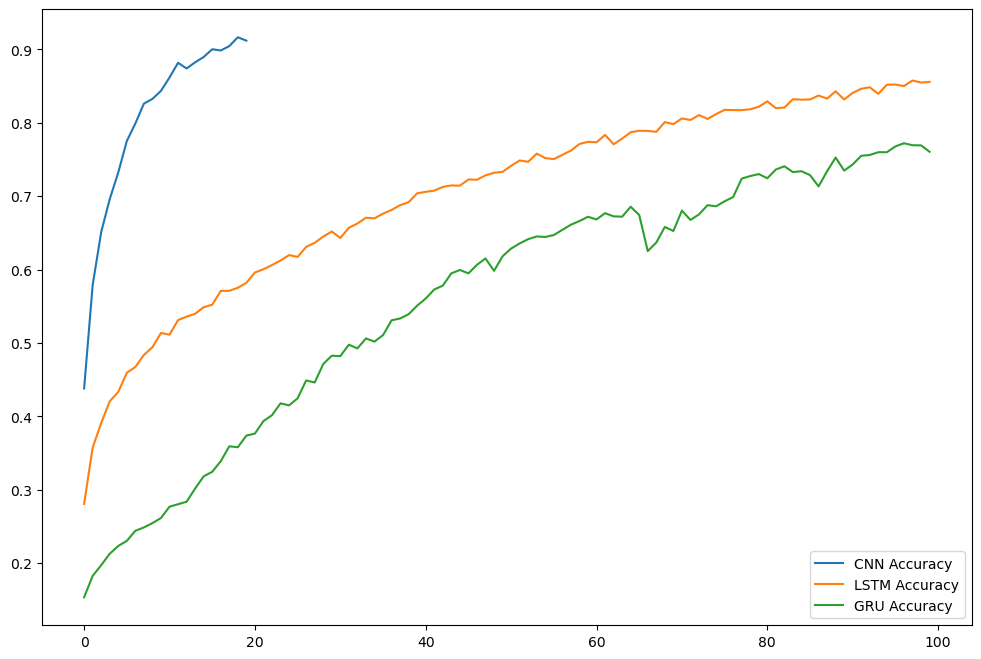

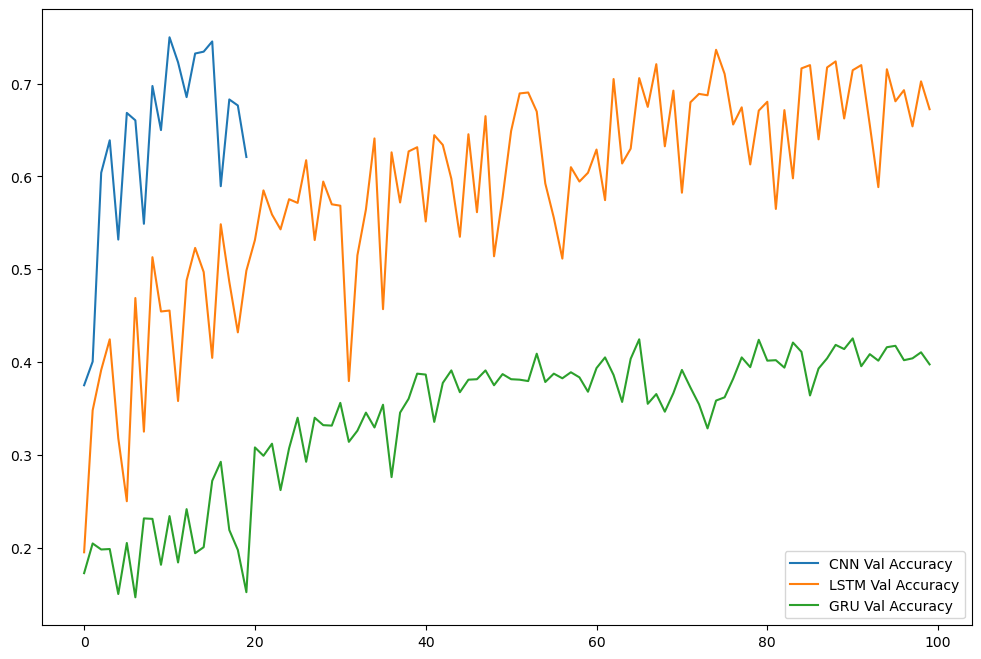

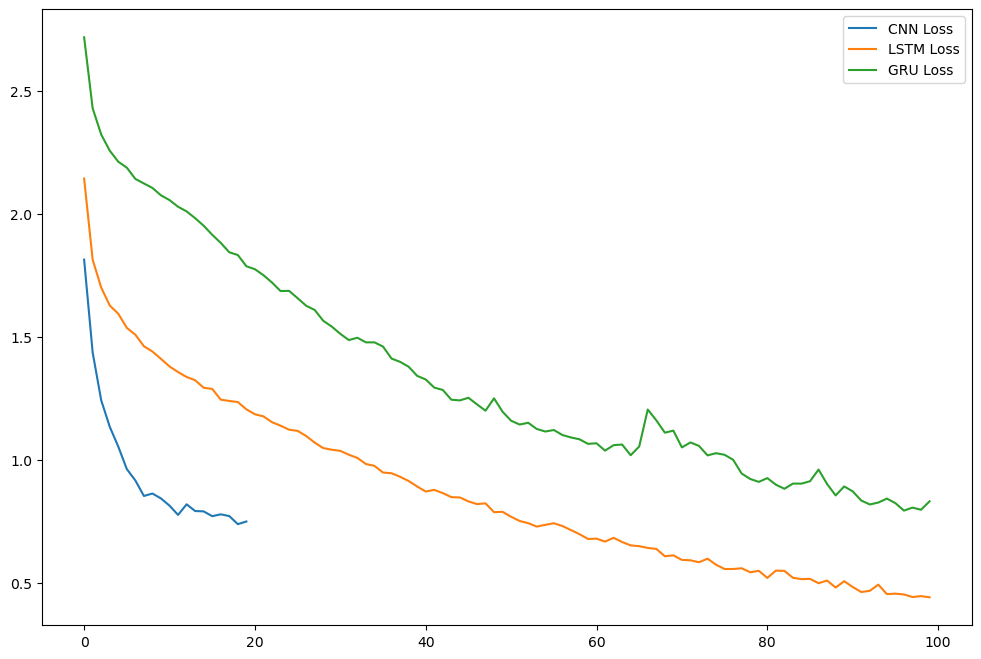

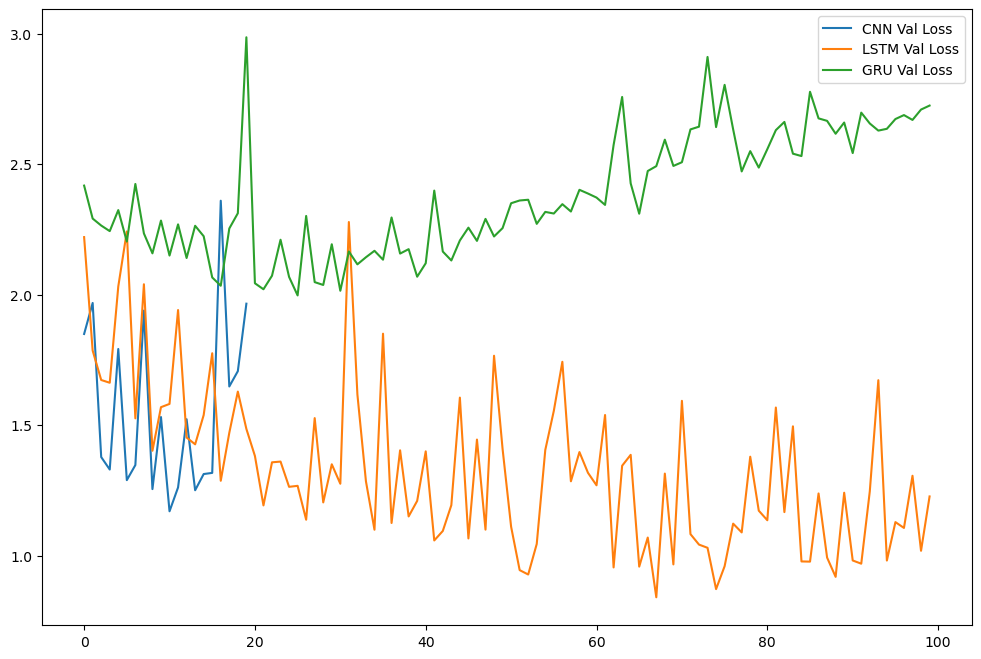

63/63 - 6s - loss: 2.0267 - accuracy: 0.6220 - 6s/epoch - 100ms/step
63/63 - 1s - loss: 1.2954 - accuracy: 0.6545 - 925ms/epoch - 15ms/step
63/63 - 3s - loss: 2.8299 - accuracy: 0.3885 - 3s/epoch - 42ms/step
CNN Test Accuracy: 0.621999979019165
LSTM Test Accuracy: 0.6545000076293945
GRU Test Accuracy: 0.38850000500679016


In [11]:
# Plotting Results
plt.figure(figsize=(12, 8))
plt.plot(cnn_history.history['accuracy'])
plt.plot(lstm_history.history['accuracy'])
plt.plot(gru_history.history['accuracy'])
plt.legend(['CNN Accuracy', 'LSTM Accuracy', 'GRU Accuracy'])
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(cnn_history.history['val_accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.plot(gru_history.history['val_accuracy'])
plt.legend(['CNN Val Accuracy', 'LSTM Val Accuracy', 'GRU Val Accuracy'])
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(cnn_history.history['loss'])
plt.plot(lstm_history.history['loss'])
plt.plot(gru_history.history['loss'])
plt.legend(['CNN Loss', 'LSTM Loss', 'GRU Loss'])
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(cnn_history.history['val_loss'])
plt.plot(lstm_history.history['val_loss'])
plt.plot(gru_history.history['val_loss'])
plt.legend(['CNN Val Loss', 'LSTM Val Loss', 'GRU Val Loss'])
plt.show()

# Evaluate Models on Test Data
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(X_test, Y_test, verbose=2)
lstm_test_loss, lstm_test_acc = lstm_model.evaluate(X_test, Y_test, verbose=2)
gru_test_loss, gru_test_acc = gru_model.evaluate(X_test, Y_test, verbose=2)

print('CNN Test Accuracy:', cnn_test_acc)
print('LSTM Test Accuracy:', lstm_test_acc)
print('GRU Test Accuracy:', gru_test_acc)

In [12]:
# Make predictions on the test set
cnn_predictions = cnn_model.predict(X_test)
lstm_predictions = lstm_model.predict(X_test)
gru_predictions = gru_model.predict(X_test)

# Combine predictions using majority voting
ensemble_predictions = np.argmax(cnn_predictions + lstm_predictions, axis=1)

# Calculate accuracy of the ensemble model
ensemble_accuracy = np.mean(ensemble_predictions == np.argmax(Y_test, axis=1))
print(f"Ensemble Model Accuracy: {ensemble_accuracy}")


63/63 [==============================] - 4s 42ms/step
Ensemble Model Accuracy: 0.7135
